# Elo7 Machine Learning Engineer

## Etapa de treinamento do modelo

Utilize este notebook para realizar o treinamento e disponibilização de um modelo de machine learning para ser consumido na API de busca de categorias.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import unidecode
import pt_core_news_sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import cloudpickle

### 1. Extração de dados


In [2]:
dataframe = pd.read_csv(os.getenv('DATASET_PATH')) 

In [3]:
dataframe.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


### 2. Transformação de dados

In [4]:
dataframe.shape

(38507, 15)

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38507 entries, 0 to 38506
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         38507 non-null  int64  
 1   seller_id          38507 non-null  int64  
 2   query              38507 non-null  object 
 3   search_page        38507 non-null  int64  
 4   position           38507 non-null  int64  
 5   title              38507 non-null  object 
 6   concatenated_tags  38505 non-null  object 
 7   creation_date      38507 non-null  object 
 8   price              38507 non-null  float64
 9   weight             38449 non-null  float64
 10  express_delivery   38507 non-null  int64  
 11  minimum_quantity   38507 non-null  int64  
 12  view_counts        38507 non-null  int64  
 13  order_counts       18117 non-null  float64
 14  category           38507 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 4.4+ MB


In [6]:
dataframe['product_id'] = dataframe['product_id'].astype('category')
dataframe['seller_id'] = dataframe['seller_id'].astype('category')
dataframe['category'] = dataframe['category'].astype('category')
dataframe['creation_date'] = pd.to_datetime(dataframe['creation_date'])

In [7]:
dataframe.isnull().sum()

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20390
category                 0
dtype: int64

In [8]:
dataframe['order_counts'] = dataframe['order_counts'].fillna(0.0)
dataframe['weight'] = dataframe['weight'].fillna(0.0)
dataframe['concatenated_tags'] = dataframe['concatenated_tags'].fillna('')

### 3. Modelagem


#### 3.1. Uso das Word Embeddings já treinadas com dados dos títulos

O modelo a ser treinado fará uso de um modelo de Word Embeddings já treinado com dados da própria Elo7. Caso deseje, você poderá realizar o treinamento do modelo de Word Embeddings com novos dados usando [este notebook](/notebooks/word-embeddings.ipynb).

In [9]:
from gensim.models import KeyedVectors
modelo_cbow = KeyedVectors.load_word2vec_format(os.getenv('WORD_EMBEDDINGS_PATH'))

#### 3.2. Criação da classe de transformação do texto em vetores usando o modelo Word2Vec CBOW.

In [10]:
# Desabilita a funções nativas do spacy, não utilizadas no projeto, para agilizar a conversão dos dados textuais.
nlp = pt_core_news_sm.load(disable=['parser', 'ner', 'tagger', 'textcat'])

In [11]:
class WordToVecTranform(BaseEstimator):
    
    def __init__(self, model):
        self.model = model

    def fit(self, x, y=None):
        return self
    
    def tokenizer(self, text):
        valid_tokens = []
        for token in nlp(text):
            if not token.is_stop and token.is_alpha:
                valid_tokens.append(unidecode.unidecode(token.text.lower()))
        return valid_tokens
    
    def text_to_vector(self, text, model):
        result_vector = np.zeros((1,300))
        words = self.tokenizer(text)
        for word in words:
            try:
                result_vector += model.get_vector(word)
            except KeyError:
                pass
        return result_vector

    def transform(self, X):
        
        X_len = len(X)
        y_len = 300
        matrix = np.zeros((X_len, y_len))

        vetor_resultante = []
        for i, texto in enumerate(X):
            matrix[i] = self.text_to_vector(texto, self.model)
        return matrix

#### 3.3. Criação dos pipelines de aprendizado de máquina

Nesta etapa são criados os pipelines compostos pela transformação dos textos em vetores, utilizando o modelo de word embeddings (CBOW) treinado numa etapa anterior, e o modelo de aprendizado de máquina LogisticRegression e DecisionTree.

##### 3.3.1. Regressão Logística

In [12]:
pipeline_logistic_regression = Pipeline([
                ('text_transform', WordToVecTranform(modelo_cbow)),
                ('model', LogisticRegression(max_iter=10000))
            ])

##### 3.3.2. Árvore de Decisão

In [13]:
pipeline_decision_tree = Pipeline([
                ('text_transform', WordToVecTranform(modelo_cbow)),
                ('model', DecisionTreeClassifier())
            ])

##### 3.3.4 Define quais pipelines serão utilizadas na etapa de validação e seleção

In [14]:
pipelines = {
    'Logistic Regression': pipeline_logistic_regression,
    'Decision Tree': pipeline_decision_tree
}

### 4. Validação do modelo


In [15]:
dataframe['category'].value_counts()

Lembrancinhas         17759
Decoração              8846
Bebê                   7026
Papel e Cia            2777
Outros                 1148
Bijuterias e Jóias      951
Name: category, dtype: int64

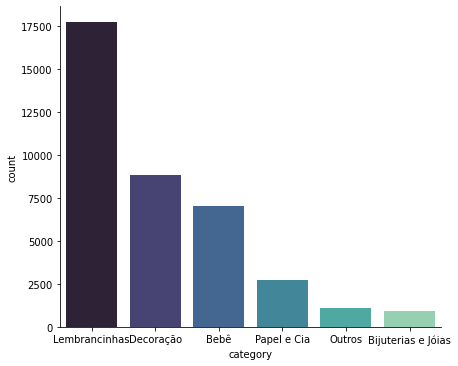

In [16]:
sns.catplot(x='category', kind='count', data=dataframe, aspect=5/4,
            palette='mako', order=dataframe['category'].value_counts().index);

Com base na análise dos dados, verifica-se um desbalanceamento das classes. Portanto, far-se-á necessário preservar o percentual de amostras de cada classe durante o treinamento e teste do modelo. Para tanto, serão utilizados técnicas para estratificar as classes, quais sejam, parâmetro stratify no treinamento/teste hold-out e uso StratifiedKFold na validação cruzada.

In [17]:
def evaluate_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

In [18]:
def show_model_result(name, model, X_test, y_test):
    y_pred = model.predict(X_test)    
    result = classification_report(y_test, y_pred)
    print(name)
    print(result)

In [19]:
def show_confusion_matrix(name, model, X_train, y_train, X_test, y_test):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
    plot_confusion_matrix(model, X_train, y_train, normalize='true', xticks_rotation=90, values_format=".3f", cmap='Blues', ax=ax[0])
    plot_confusion_matrix(model, X_test, y_test, normalize='true', xticks_rotation=90, values_format=".3f", cmap='Blues', ax=ax[1])
    ax[0].title.set_text('Treinamento')
    ax[1].title.set_text('Teste')
    fig.suptitle(name, fontsize=16)
    fig.tight_layout()

##### 4.1. Definição dos dados de entrada e saída utilizados no modelo

In [20]:
X = dataframe['title']
y = dataframe['category']

##### 4.2. Uso da validação hold-out (80%/20%)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)

In [22]:
for name, pipeline in pipelines.items():
    show_model_result(name, evaluate_model(pipeline, X_train, y_train), X_test, y_test)

Logistic Regression
                    precision    recall  f1-score   support

              Bebê       0.86      0.79      0.82      1405
Bijuterias e Jóias       0.86      0.88      0.87       190
         Decoração       0.85      0.87      0.86      1769
     Lembrancinhas       0.86      0.92      0.89      3552
            Outros       0.62      0.40      0.49       230
       Papel e Cia       0.71      0.62      0.66       556

          accuracy                           0.84      7702
         macro avg       0.79      0.74      0.76      7702
      weighted avg       0.84      0.84      0.84      7702

Decision Tree
                    precision    recall  f1-score   support

              Bebê       0.81      0.80      0.81      1405
Bijuterias e Jóias       0.76      0.82      0.78       190
         Decoração       0.84      0.82      0.83      1769
     Lembrancinhas       0.88      0.89      0.88      3552
            Outros       0.49      0.50      0.50       230
  

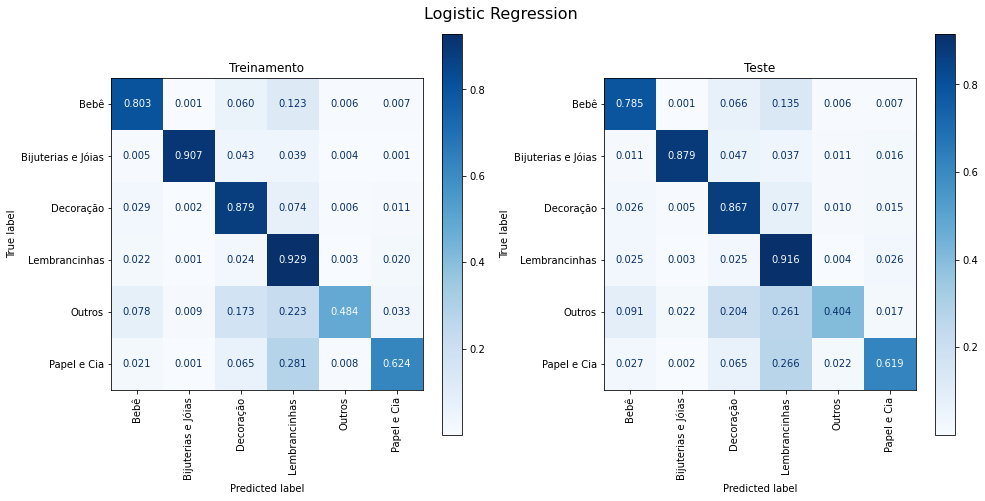

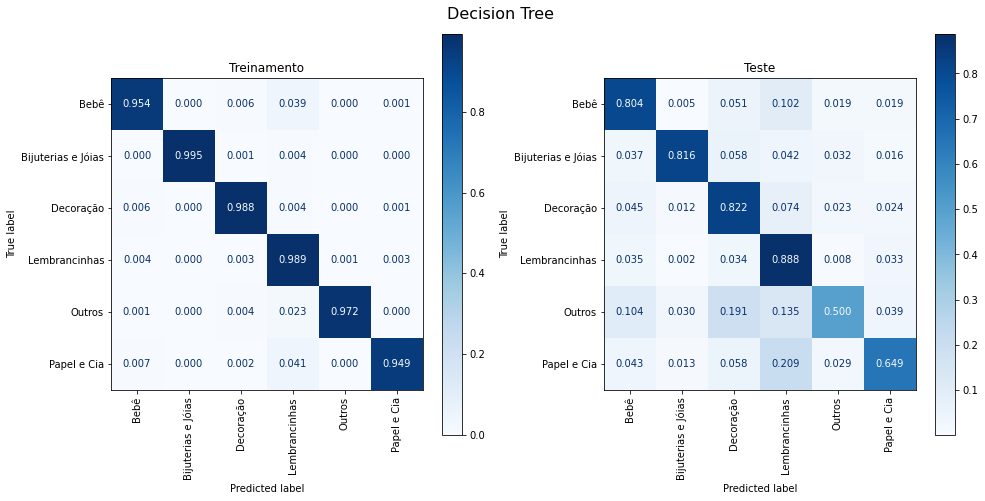

In [23]:
for name, pipeline in pipelines.items():
    show_confusion_matrix(name, pipeline, X_train, y_train, X_test, y_test)

##### 4.3. Uso da validação cruzada

In [24]:
def cross_validation(pipeline, X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    results = cross_validate(pipeline, X,
                         y=y,
                         cv=cv,
                         return_train_score=False,
                         n_jobs=-1)
    return results['test_score'].mean()

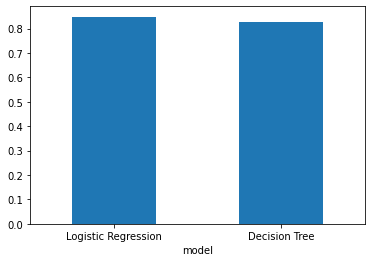

In [25]:
models = []
results = []

for name, pipeline in pipelines.items():
    models.append(name)
    results.append(cross_validation(pipeline, X, y))
    
df_result = pd.DataFrame({'model': models, 'accuracy':results})
df_result.plot.bar(x='model', y='accuracy', rot=0, legend=False);

### 5. Exportação do modelo

In [26]:
def save_model(model, path):
    with open(path, 'wb') as f:
        cloudpickle.dump(model, f)

In [27]:
best_model = df_result.sort_values('accuracy', ascending=False).iloc[0]['model']
save_model(pipelines.get(best_model), os.getenv('MODEL_PATH'))
print(f'{best_model} saved.')

Logistic Regression saved.
